In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Excel dosyasını yükle
file_path = 'elektrik_veri_hashed.xlsx'
xls = pd.ExcelFile(file_path)
# Sayfa isimlerini görüntüle
print("Sayfa isimleri:", xls.sheet_names)
# Her sayfayı ayrı DataFrame'e yükle
df_tahsilat = pd.read_excel(xls, sheet_name='Tahsilat')
df_tahsilat_1 = pd.read_excel(xls, sheet_name='Tahsilat 1')
df_tahakkuk = pd.read_excel(xls, sheet_name='Tahakkuk') # Hamamözü
df_tahakkuk_1 = pd.read_excel(xls, sheet_name='Tahakkuk 1') # Gümüşhacıköy
df_tahakkuk_2 = pd.read_excel(xls, sheet_name='Tahakkuk 2')

Sayfa isimleri: ['Tahsilat', 'Tahsilat 1', 'Tahakkuk', 'Tahakkuk 1', 'Tahakkuk 2']


In [13]:
# Önce tüm tüketim verilerini birleştirelim
df_tahakkuk['ilce_adi'] = 'Hamamözü'
df_tahakkuk_1['ilce_adi'] = 'Gümüşhacıköy'
df_tahakkuk_2['ilce_adi'] = 'Göynücek'
df_tum_tahakkuk = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2], ignore_index=True)
df_tum_tahakkuk['kwh'] = pd.to_numeric(df_tum_tahakkuk['kwh'], errors='coerce') 

df_musteri = df_tum_tahakkuk.groupby('sozlesme_hesap_no').agg({
    'kwh': 'sum',                        # Toplam tüketim
    'hesap_sinifi': 'first',             # Müşterinin sınıfı (Mesken, Ticarethane vb.)
    'ilce_adi': 'first'                  # Müşterinin ilçesi
}).reset_index()

# Sütun ismini daha anlaşılır yapalım
df_musteri.rename(columns={'kwh': 'toplam_tuketim'}, inplace=True)

# Müşterileri en çok tüketenden en aza doğru sıralayalım
df_musteri = df_musteri.sort_values(by='toplam_tuketim', ascending=False)

print(f"Toplam Tekil Müşteri Sayısı: {len(df_musteri)}")
df_musteri.head()

Toplam Tekil Müşteri Sayısı: 28290


,sozlesme_hesap_no,toplam_tuketim,hesap_sinifi,ilce_adi
18165,6414845714,2634973.74,6,Gümüşhacıköy
21373,7553584057,1636590.30,T019,Gümüşhacıköy
23799,8398443615,1238340.68,A002,Gümüşhacıköy
13507,4777252213,857108.70,T019,Gümüşhacıköy
10728,3798287663,782153.22,4,Gümüşhacıköy


In [17]:
# 1. Kümülatif (Birikimli) Tüketimi Hesapladım
df_musteri['kumulatif_tuketim'] = df_musteri['toplam_tuketim'].cumsum()

# 2. Toplam Tüketimin Yüzdesini Hesaplayalım
toplam_enerji = df_musteri['toplam_tuketim'].sum()
df_musteri['kumulatif_yuzde'] = (df_musteri['kumulatif_tuketim'] / toplam_enerji) * 100

# 3. Segmentlere Ayırıyoruz (A, B, C Sınıflandırması)
# A Grubu: Tüketimin ilk %80'ini oluşturanlar (En değerliler)
# B Grubu: %80 ile %95 arasındakiler
# C Grubu: Geriye kalan küçük tüketiciler (%95 - %100)

def segment_bul(yuzde):
    if yuzde <= 80:
        return 'A (VIP)'
    elif yuzde <= 95:
        return 'B (Standart)'
    else:
        return 'C (Düşük)'

df_musteri['Segment'] = df_musteri['kumulatif_yuzde'].apply(segment_bul)

# Sonuçları görelim
ozet_segment = df_musteri['Segment'].value_counts()
print(ozet_segment)
print("\nSegmentlerin Toplam Müşteriye Oranı:")
print(df_musteri['Segment'].value_counts(normalize=True) * 100)

Segment
C (Düşük)       12399
A (VIP)          8441
B (Standart)     7450
Name: count, dtype: int64

Segmentlerin Toplam Müşteriye Oranı:
Segment
C (Düşük)       43.828208
A (VIP)         29.837398
B (Standart)    26.334394
Name: proportion, dtype: float64


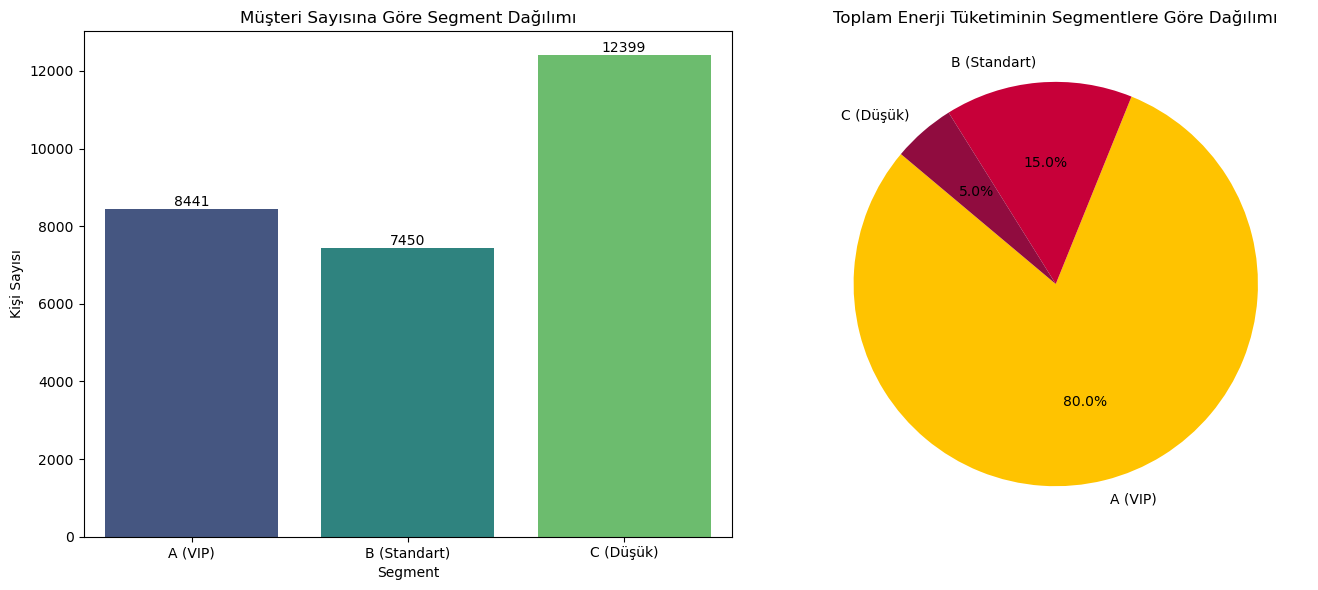

In [19]:
# Grafik Alanı
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafik 1: Müşteri Sayısı Dağılımı (Bar Chart)
sns.countplot(x='Segment', data=df_musteri, order=['A (VIP)', 'B (Standart)', 'C (Düşük)'], palette='viridis', ax=ax1)
ax1.set_title('Müşteri Sayısına Göre Segment Dağılımı')
ax1.set_ylabel('Kişi Sayısı')

# Her barın üzerine sayıyı yazalım
for container in ax1.containers:
    ax1.bar_label(container)

# Grafik 2: Toplam Tüketime Katkı (Pie Chart)
tuketim_segment = df_musteri.groupby('Segment')['toplam_tuketim'].sum()
ax2.pie(tuketim_segment, labels=tuketim_segment.index, autopct='%1.1f%%', 
        colors=['#FFC300', '#C70039', '#900C3F'], startangle=140)
ax2.set_title('Toplam Enerji Tüketiminin Segmentlere Göre Dağılımı')

plt.tight_layout()
plt.show()

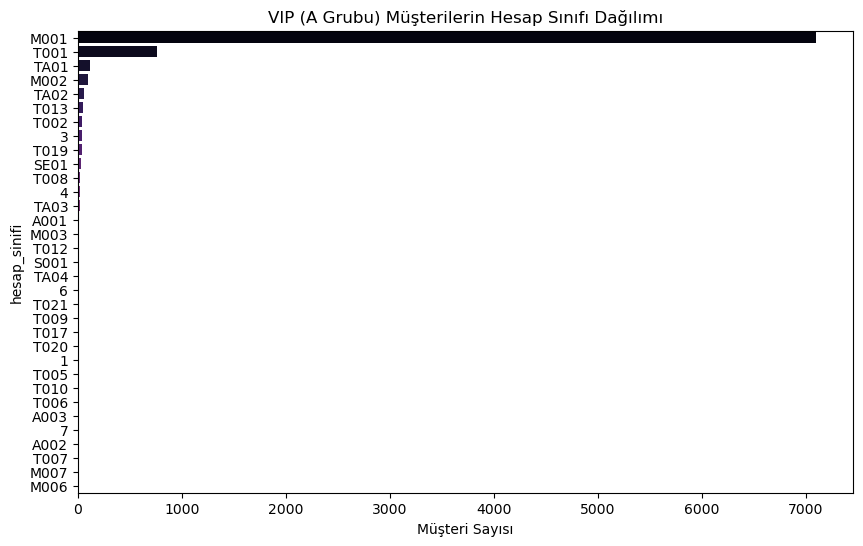

VIP Müşterilerin İlçe Dağılımı:
ilce_adi
Gümüşhacıköy    5772
Göynücek        1963
Hamamözü         706
Name: count, dtype: int64


In [23]:
# Sadece A (VIP) müşterilerini filtrele
vip_musteriler = df_musteri[df_musteri['Segment'] == 'A (VIP)']

# VIP Müşterilerin Hesap Sınıfına Göre Dağılımı
plt.figure(figsize=(10, 6))
sns.countplot(y='hesap_sinifi', data=vip_musteriler, order=vip_musteriler['hesap_sinifi'].value_counts().index, palette='magma')
plt.title('VIP (A Grubu) Müşterilerin Hesap Sınıfı Dağılımı')
plt.xlabel('Müşteri Sayısı')
plt.show()

# VIP Müşterilerin İlçelere Göre Dağılımı
print("VIP Müşterilerin İlçe Dağılımı:")
print(vip_musteriler['ilce_adi'].value_counts())

## 1. Pareto Analizi Yorumu (80/20 Kuralı Doğrulaması)
Bu analizi, Pasta Grafiği ve Segment Dağılımı çıktılarının altına ekleyebilirsin.

Analiz Bulgusu: Enerji Tüketiminin Asimetrik Dağılımı

Yaptığımız Pareto (ABC) analizi, enerji tüketiminde "80/30 Kuralı" diyebileceğimiz bir yapıyı ortaya çıkarmıştır:

A Grubu (VIP): Müşteri tabanımızın %29.8'ini oluşturan 8,441 müşteri, toplam enerji tüketiminin %80'ini tek başına gerçekleştirmektedir.

C Grubu (Düşük Tüketim): Müşterilerin sayıca en kalabalık grubu olan %43.8'lik kesim (12,399 kişi), toplam tüketimin sadece %5'inden azını oluşturmaktadır.

İş İçgörüsü: Şirket gelirlerinin büyük kısmı, müşteri sayısının üçte birinden daha azına (VIP gruba) bağlıdır. Bu durum, gelir kararlılığı açısından bir risktir ancak aynı zamanda hedefli pazarlama için büyük bir fırsattır.

## 2. VIP Müşteri Profili ve Bölgesel Analiz
Bu analizi, İlçe Dağılımı ve Hesap Sınıfı grafiklerinin altına ekleyebilirsin.

Bölgesel ve Sınıfsal Odak

VIP (A Segmenti) müşterilerin dağılımına baktığımızda çok net bir bölgesel yoğunlaşma görüyoruz:

Gümüşhacıköy Dominasyonu: VIP müşterilerin %68'i (5,772 müşteri) Gümüşhacıköy ilçesindedir. Bu ilçe, bölgenin sanayi ve ticari merkezi konumundadır.

Hamamözü: Sadece 706 VIP müşteri ile en düşük ticari hacme sahip ilçedir.

Ayrıca hesap sınıfı dağılımı (kodlara bakıldığında), yüksek tüketimin genellikle Sanayi, Ticarethane ve Tarımsal Sulama abonelerinden kaynaklandığını doğrulamaktadır.

## 3. Stratejik İş Önerileri (Final Raporu)
Notebook'un en sonuna, "Sonuç ve Öneriler" başlığı altında bu maddeleri eklemelisin. Hoca veya yönetici en çok buraya dikkat edecektir.

🚀 Stratejik Eylem Planı

Elde edilen veriler ışığında şirket için önerilen aksiyonlar şunlardır:

VIP Müşteri Yönetimi (Retention):

Gelirin %80'ini sağlayan Gümüşhacıköy ağırlıklı bu kitleye "Özel Müşteri Temsilcisi" atanmalıdır.

Sanayi ve ticarethane tarifelerindeki olası memnuniyetsizlikler, bu grupta anında ciro kaybına yol açar. Proaktif iletişim kurulmalıdır.

Operasyonel Verimlilik (C Segmenti):

Müşterilerin %44'ünü oluşturan ama gelirin sadece %5'ini getiren "C Grubu" (Düşük Tüketim) için maliyetler düşürülmelidir.

Bu grup için Dijital Fatura, SMS ile bilgilendirme ve Otomatik Ödeme teşvik edilerek operasyonel yük (sayaç okuma, kağıt fatura vb.) azaltılmalıdır.

Tarımsal Kampanya Fırsatı:

Göynücek ve Gümüşhacıköy'deki yüksek tüketimli tarımsal abonelere, sulama sezonunda geçerli özel ödeme planları sunularak tahsilat riski düşürülebilir.